In [2]:
pip install pandas

     |████████████████████████████████| 10.2 MB 3.2 MB/s eta 0:00:01    |████████████████████████████▎   | 9.0 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn

     |████████████████████████████████| 7.2 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 309 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 4.0 MB/s eta 0:00:01     |████████████                    | 10.8 MB 3.3 MB/s eta 0:00:06     |████████████████████████████▏   | 25.3 MB 2.7 MB/s eta 0:00:02
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tqdm

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [11]:
trainFile=pd.read_csv('train_merged.csv',encoding='latin-1')
testFile=pd.read_csv('test_merged.csv', encoding='latin-1')

In [12]:
trainFile.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed Spider Man after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [13]:
trainFile['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [14]:
totaldata= trainFile['articleBody'].tolist() + trainFile['Headline'].tolist()+testFile['articleBody'].tolist()+testFile['Headline'].tolist()

In [15]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=80, stop_words='english')

In [16]:
tfidf_vect.fit(totaldata)

TfidfVectorizer(max_features=80, stop_words='english', token_pattern='\\w{1,}')

In [17]:
train_head_vec= tfidf_vect.transform(trainFile['Headline'])
train_body_vec= tfidf_vect.transform(trainFile['articleBody'])
test_head_vec= tfidf_vect.transform(testFile['Headline'])
test_body_vec= tfidf_vect.transform(testFile['articleBody'])

In [92]:
mydata['headline']='Low-Energy Intense Pulsed Light for Hair Removal at Home'

NameError: name 'mydata' is not defined

In [91]:
mydata_head_vec = tfidf_vect.transform(r'Low-Energy Intense Pulsed Light for Hair Removal at Home')

ValueError: Iterable over raw text documents expected, string object received.

In [18]:
train_head_vec

<49972x80 sparse matrix of type '<class 'numpy.float64'>'
	with 92647 stored elements in Compressed Sparse Row format>

In [19]:
train_body_vec

<49972x80 sparse matrix of type '<class 'numpy.float64'>'
	with 825803 stored elements in Compressed Sparse Row format>

In [21]:
pip install nltk

     |████████████████████████████████| 1.5 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
# run and tested
import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)




def word_overlap_features(features, headline, body):
    # common word/ total word
    clean_headline = clean(headline)
    clean_body = clean(body)
    clean_headline = get_tokenized_lemmas(clean_headline)
    clean_body = get_tokenized_lemmas(clean_body)
    feature = len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))
    features.append(feature)
    return features




def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):
    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    def other_feature(headline, body):
        features=[]
        features= word_overlap_features(features, headline, body)
        return features
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        lst= binary_co_occurence(headline, body) + binary_co_occurence_stops(headline, body) + count_grams(headline, body)+ other_feature(headline, body)
        X.append(lst)


    X =np.array(X)
    return X

In [24]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vidushibhargava/nltk_data...


True

In [25]:
train_handF= hand_features(trainFile['Headline'].tolist(), trainFile['articleBody'].tolist())
test_handF=hand_features(testFile['Headline'].tolist(), testFile['articleBody'].tolist())

49972it [06:10, 135.03it/s]
25413it [03:24, 124.08it/s]


In [26]:
from scipy.sparse import  hstack

In [27]:
train_final= hstack([train_head_vec,train_body_vec]).toarray()


In [28]:
test_final= hstack([test_head_vec,test_body_vec]).toarray()

In [29]:
train_final =np.concatenate((train_final,train_handF), axis=1)
test_final =np.concatenate((test_final,test_handF), axis=1)

In [30]:
print(type(train_final), train_final.shape, test_final.shape)

<class 'numpy.ndarray'> (49972, 187) (25413, 187)


In [31]:
trainFile.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed Spider Man after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [32]:
train_labels= trainFile['Stance'].copy()
test_labels= testFile['Stance'].copy()

In [32]:
test_labels.shape

(25413,)

In [35]:
#test_labels_array = test_labels.values

# Reshape numpy array
#test_labels_reshaped = test_labels_array.reshape(-1, 1)

# Naive Bayes

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.34)
mnb.fit(train_final, train_labels)

MultinomialNB(alpha=0.34)

In [38]:
#testing naive bayes
prediction = mnb.predict(test_final)
accuracy_score(test_labels,prediction)

0.8256404202573486

In [39]:
np.unique(prediction)

array(['agree', 'disagree', 'discuss', 'unrelated'], dtype='<U9')

In [41]:
pip install matplotlib

     |████████████████████████████████| 8.5 MB 3.1 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 61 kB 4.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [43]:
matrix1 = confusion_matrix(test_labels, prediction)

In [44]:
matrix1

array([[  749,    80,   828,   246],
       [  210,    31,   258,   198],
       [  847,    93,  2856,   668],
       [  217,    57,   729, 17346]])

In [45]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

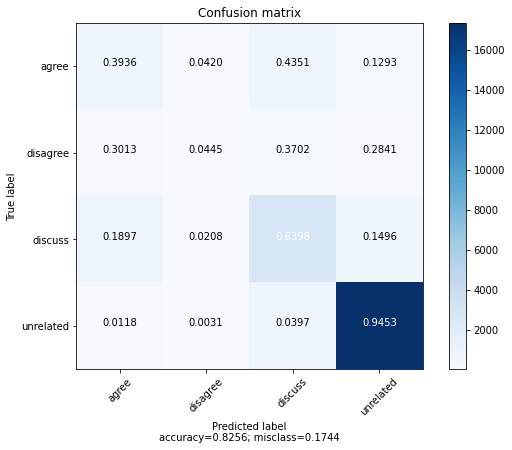

In [46]:
plot_confusion_matrix(cm=matrix1,target_names=['agree', 'disagree', 'discuss', 'unrelated'])

# Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [48]:
param_dist = {"n_estimators":[100,200,300,500,700,1000],
              "max_features": [20,40,60,80,100,120,140,160,187],
              "bootstrap": [True, False],
              'class_weight':[None,'balanced'], 
                'criterion':['entropy','gini'],
                'max_depth':[None,5,10,15,20,30,50,70],
                'min_samples_leaf':[1,2,5,10,15,20], 
                'min_samples_split':[2,5,10,15,20]
                  }

In [51]:
clf = RandomForestClassifier()

In [52]:
from sklearn.model_selection import RandomizedSearchCV

In [53]:
# run randomized search
n_iter_search = 10
# n_iter parameter of RandomizedSeacrhCV controls, how many 
# parameter combination will be tried; out of all possible given values

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring='f1_micro',
                                   cv=10,
                                  n_jobs=-1,verbose=20)

In [54]:
train_labels.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [55]:
train_final.shape

(49972, 187)

In [56]:
label_mapping = {'unrelated': 0, 'discuss': 1, 'agree': 2, 'disagree': 3}
train_labels = train_labels.map(label_mapping)
train_labels

0        0
1        0
2        0
3        0
4        0
        ..
49967    2
49968    2
49969    2
49970    2
49971    2
Name: Stance, Length: 49972, dtype: int64

In [60]:
#label_mapping = {'unrelated': 0, 'discuss': 1, 'agree': 2, 'disagree': 3}
test_labels = test_labels.map(label_mapping)
test_labels

0        0
1        2
2        0
3        0
4        0
        ..
25408    3
25409    2
25410    3
25411    3
25412    2
Name: Stance, Length: 25413, dtype: int64

In [53]:
random_search.fit(train_final,train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 47

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 500, 700, 1000], 'max_features': [20, 40, 60, 80, 100, 120, 140, 160, 187], 'bootstrap': [True, False], 'class_weight': [None, 'balanced'], 'criterion': ['entropy', 'gini'], 'max_depth': [None, 5, 10, 15, 20, 30, 50, 70], 'min_samples_leaf': [1, 2, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=T

In [54]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: 0.89134 (std: 0.00654)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 60, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.88898 (std: 0.00752)
Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 100, 'max_depth': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.88890 (std: 0.01067)
Parameters: {'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 60, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.88860 (std: 0.00838)
Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 100, 'max_depth': 70, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

M

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                            max_features=60, max_depth=30, criterion='entropy', 
                            class_weight=None, bootstrap=False)
rf.fit(train_final,train_labels)
y_pred = rf.predict(test_final)
#accuracy = rf.score(test_final,test_labels)
accuracy = accuracy_score(y_pred,test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8623145634124267


In [61]:
#y_pred

array([0, 1, 0, ..., 0, 0, 1])

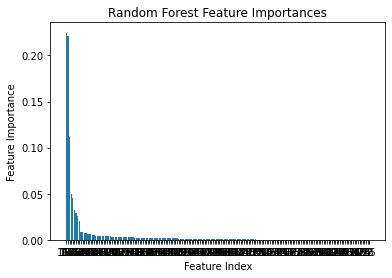

In [64]:
import matplotlib.pyplot as plt
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), sorted_idx)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

In [65]:
#feature_importances

array([4.44310968e-05, 0.00000000e+00, 1.46516612e-05, 5.71422913e-04,
       1.71387460e-03, 2.61978927e-03, 1.15754147e-04, 7.29263375e-06,
       4.22536294e-03, 5.94316400e-06, 4.44892540e-04, 0.00000000e+00,
       0.00000000e+00, 1.50872847e-03, 3.42232526e-05, 3.26830311e-06,
       9.86775874e-05, 6.44098551e-04, 0.00000000e+00, 2.36665020e-05,
       0.00000000e+00, 0.00000000e+00, 1.89482269e-04, 5.17131637e-05,
       2.67171282e-03, 1.16380604e-03, 0.00000000e+00, 1.31755834e-03,
       5.12680999e-05, 3.67230574e-05, 7.91240108e-04, 0.00000000e+00,
       1.80796035e-04, 1.53452820e-06, 0.00000000e+00, 0.00000000e+00,
       1.05936714e-03, 1.76568802e-05, 2.18356704e-04, 0.00000000e+00,
       5.57773998e-04, 2.27824816e-05, 3.77002950e-05, 0.00000000e+00,
       1.39588331e-04, 0.00000000e+00, 1.66024609e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.22049552e-03, 1.83663547e-05,
       6.12064528e-04, 1.66061918e-04, 2.53217102e-02, 0.00000000e+00,
      

In [24]:
#sorted_idx

array([163, 162, 177, 176, 186, 164,  54, 160, 161, 178, 134,  99, 135,
       104,  85, 142, 179, 159,  81, 141, 146, 144, 125,   8, 100, 133,
       165, 114, 131, 150, 121, 102, 145, 126,  97, 157,  83, 116,  69,
       120,  88, 108,   5,  24, 105,  89, 158, 132, 109, 156,  82, 117,
       143, 137, 136, 110,  84, 166, 151, 149, 118, 113, 139, 138, 130,
        50,  13, 123, 153, 103,  25, 127, 107, 106, 154,  93, 124, 112,
        92,  36,   4,  95, 147, 128,  27,  86, 111, 180,  30, 122, 101,
        87,  94, 148,  64,  96,  61,  90,  80,  98, 129,  40, 140,  52,
       155, 152, 181, 115,  70,  17,   3,  91,  10,  77,  22, 119,  71,
        44,  57,  38, 184,  53,  32,  16,  75,   6,  28,   0,  14, 182,
        29,  23,  76,  41,  19,  42,  78,  37,  56, 183,   9,  58,   7,
        59,  51,  15,  62,  63,  48, 185,  65,  33,  20,  46,  35, 167,
       172, 171,   1,   2,  12, 169,  11, 168, 170,  18,  60, 174,  79,
        21,  43,  45,  66,  39,  67,  47,  68,  34, 173,  31,  7

In [66]:
matrix2 = confusion_matrix(test_labels, y_pred)

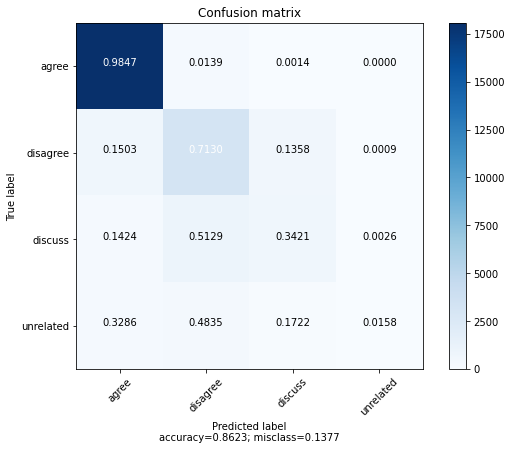

In [67]:
plot_confusion_matrix(cm=matrix2,target_names=['agree', 'disagree', 'discuss', 'unrelated'])


In [1]:
from sklearn.model_selection import cross_val_score

In [2]:
cross_val_score?

Signature: cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv='warn', n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score='raise-deprecating')
Docstring:
Evaluate a score by cross-validation

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
estimator : estimator object implementing 'fit'
    The object to use to fit the data.

X : array-like
    The data to fit. Can be for example a list, or an array.

y : array-like, optional, default: None
    The target variable to try to predict in the case of
    supervised learning.

groups : array-like, with shape (n_samples,), optional
    Group labels for the samples used while splitting the dataset into
    train/test set.

scoring : string, callable or None, optional, default: None
    A string (see model evaluation documentation) or
    a scorer callable object / function with signature
    ``scorer(estimator, X, y)``.

cv : int, cross-validation generator or an iterabl

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [69]:
knn=KNeighborsClassifier(n_neighbors=100)
svm=SVC()

In [26]:
cross_val_score(knn,train_final,train_labels,cv=10,scoring='f1_micro',n_jobs=-1)

array([0.87034814, 0.87394958, 0.86994798, 0.8747499 , 0.85614246,
       0.85951571, 0.86471883, 0.86091655, 0.87770216, 0.86406406])

In [70]:
knn.fit(train_final,train_labels)

KNeighborsClassifier(n_neighbors=100)

In [71]:
knn_prediction = knn.predict(test_final)
accuracy_score(test_labels,knn_prediction)

0.8485814346987762

In [72]:
matrix3 = confusion_matrix(test_labels, knn_prediction)

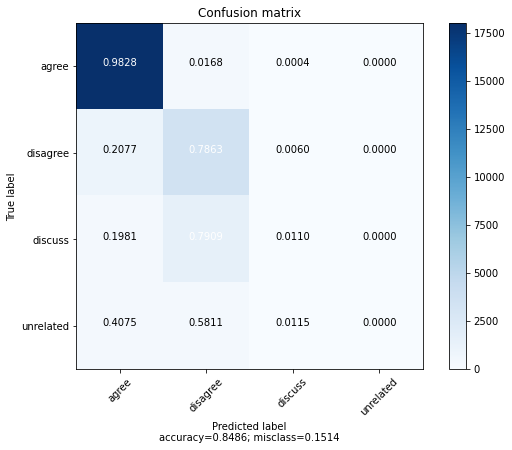

In [73]:
plot_confusion_matrix(cm=matrix3,target_names=['agree', 'disagree', 'discuss', 'unrelated'])

In [74]:
svm.fit(train_final,train_labels)
svm_prediction = svm.predict(test_final)
accuracy_score(test_labels,svm_prediction)

0.856175972927242

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM
from keras.models import Model

# Define base models
random_forest = rf
naive_bayes = MultinomialNB(alpha=0.34)
neural_nets = MLPClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=100)
inp = Input(shape=(train_final.shape[1],))
# lstm = LSTM(150,return_sequences=True)(inp)
lay1= Dense(200, activation= 'tanh')(inp)
lay1= Dense(100, activation= 'sigmoid')(lay1)
# lay1= Dropout(0.3)(lay1)
lay2= Dense(40, activation= 'sigmoid')(lay1)
outp= Dense(4,activation='sigmoid')(lay2)
model= Model(inputs=[inp], outputs=[outp])
svm = SVC()

# Fit and evaluate ensemble model using cross-validation
ensemble_model = Pipeline([
    ('random_forest', random_forest),
    ('neural_nets', model),
    ('knn', knn),
    ('svm', svm)
])

ensemble_scores = cross_val_score(ensemble_model, train_final, train_labels, cv=5)  
ensemble_accuracy = ensemble_scores.mean() * 100
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}%')


TypeError: All intermediate steps should be transformers and implement fit and transform. 'RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=30, max_features=60,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)' (type <class 'sklearn.ensemble.forest.RandomForestClassifier'>) doesn't

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can specify the number of neighbors (k) here

In [38]:
scores = cross_val_score(knn, train_final, train_labels, cv=10, scoring='f1_micro', n_jobs=-1)

In [39]:
avg_score = scores.mean()
std_score = scores.std()

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],  # example values for n_neighbors
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3],  # example values for p
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],  # example values for leaf_size
    'metric': ['euclidean', 'manhattan']  # example values for metric
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, scoring='f1_micro', cv=10, n_jobs=-1)
grid_search.fit(train_final, train_labels)

# Get the best hyperparameters and corresponding F1 score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


KeyboardInterrupt: 

In [37]:
clf1=KNeighborsClassifier(n_neighbors=100)
clf2=SVC()
clf3=MultinomialNB(alpha=0.34)
clf4=Model(inputs=[inp], outputs=[outp])
clf5=RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                            max_features=60, max_depth=30, criterion='entropy', 
                            class_weight=None, bootstrap=False)

Algos=[clf1,clf2,clf3,clf4,clf5]

In [39]:
rows=train_final.shape[0]
rows

49972

In [43]:
layer1=pd.DataFrame({'clf'+str(i):np.zeros(rows) for i in range(1,len(Algos)+1)})
layer1

,clf1,clf2,clf3,clf4,clf5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


In [45]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)

In [50]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB

fold = 1
for train, left_out_chunk in kf.split(train_final):
    print('fold number : ', fold)

    for i, clf in enumerate(Algos):
        print('Algo number :', i + 1)

        train_train_final = pd.DataFrame(train_final).loc[train]
        train_train_labels = train_labels[train]

        train_final_left_out_chunk = pd.DataFrame(train_final).loc[left_out_chunk]

        # Initialize and fit GaussianNB classifier
        #clf = GaussianNB()
        clf.fit(train_train_final, train_train_labels)
        p = clf.predict_proba(train_final_left_out_chunk)[:, 1]

        layer1.iloc[left_out_chunk, i] = p

    fold += 1


fold number :  1
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  2
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  3
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  4
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  5
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  6
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  7
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  8
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  9
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5
fold number :  10
Algo number : 1
Algo number : 2
Algo number : 3
Algo number : 4
Algo number : 5


In [51]:
layer1

,clf1,clf2,clf3,clf4,clf5
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,4.850940e-27,4.850940e-27,4.850940e-27,4.850940e-27,4.850940e-27
3,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
5,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
6,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
7,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
8,2.824496e-26,2.824496e-26,2.824496e-26,2.824496e-26,2.824496e-26
9,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [52]:
rows=test_final.shape[0]
layer2_test=pd.DataFrame({'clf'+str(i):np.zeros(rows) for i in range(1,len(Algos)+1)})

In [53]:
layer2_test

,clf1,clf2,clf3,clf4,clf5
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


In [55]:
for i,clf in enumerate(Algos):
    
    print( 'Algo number',i+1)
    clf.fit(train_final,train_labels)
    p=clf.predict_proba(test_final)[:,1]
    
    layer2_test.iloc[:,i]=p

Algo number 1
Algo number 2


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


AttributeError: predict_proba is not available when  probability=False

In [56]:
def create_neural_network(input_shape, depth=5, batch_mod=2, num_neurons=20, drop_rate=0.1, learn_rate=.01,
                      r1_weight=0.02,
                      r2_weight=0.02):
    '''A neural network architecture built using keras functional API'''
    act_reg = l1(r2_weight)
    kern_reg = l1(r1_weight)
    
    inputs = Input(shape=(train_final.shape[1],))
    batch1 = Dense(200, activation= 'tanh')(inputs)
    hidden1 = Dense(100, activation= 'sigmoid')(batch1)
    batch2= Dense(40, activation= 'sigmoid')(batch1)
    dropout1 = Dropout(drop_rate)(hidden1)
    hidden2 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(dropout1)
    
    skip_list = [batch1]
    last_layer_in_loop = hidden2
    
    for i in range(depth):
        added_layer = concatenate(skip_list + [last_layer_in_loop])
        skip_list.append(added_layer)
        b1 = None
        #Apply batch only on every i % N layers
        if i % batch_mod == 2:
            b1 = BatchNormalization()(added_layer)
        else:
            b1 = added_layer
        
        h1 = Dense(num_neurons, activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(b1)
        d1 = Dropout(drop_rate)(h1)
        h2 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d1)
        d2 = Dropout(drop_rate)(h2)
        h3 =  Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d2)
        d3 = Dropout(drop_rate)(h3)
        h4 =  Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d3)
        last_layer_in_loop = h4
        c1 = concatenate(skip_list + [last_layer_in_loop])
        output = Dense(4,activation='sigmoid')(c1)
    
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam()
    optimizer.learning_rate = learn_rate
    
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [57]:
def get_stacking(input_shape=None):
    '''A stacking model that consists of CatBoostRegressor,
    XGBRegressor, a linear model, and some neural networks'''
    # First we create a list called "level0", which consists of our base models"
    # Basically, you'll want to pick a assortment of your favorite machine learning models
    # These models will get passed down to the meta-learner later
    level0 = list()
    level0.append(('cat', CatBoostRegressor(verbose=False)))
    level0.append(('cat2', CatBoostRegressor(verbose=False, learning_rate=.0001)))
    level0.append(('xgb', XGBRegressor()))
    level0.append(('xgb2', XGBRegressor(max_depth=5, learning_rate=.0001)))
    level0.append(('linear', LogisticRegression()))
    level0.append(('rf', RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                            max_features=60, max_depth=30, criterion='entropy', 
                            class_weight=None, bootstrap=False)))
    level0.append(('svm', SVC()))
    level0.append(('nb', MultinomialNB(alpha=0.34)))
    level0.append(('knn', KNeighborsClassifier(n_neighbors=100)))
    #Create 5 neural networks using our function above
    for i in range(5):
        # Wrap our neural network in a Keras Regressor to make it
        #compatible with StackingRegressor
        keras_reg = KerasRegressor(
                create_neural_network, # Pass in function
                input_shape=input_shape, # Pass in the dimensions to above function
                epochs=6,
                batch_size=32,
                verbose=False)
        keras_reg._estimator_type = "regressor"
        # Append to our list
        level0.append(('nn_{num}'.format(num=i), keras_reg))
    # The "meta-learner" designated as the level1 model
    # In my experience Linear Regression performs best
    # but feel free to experiment with other models
    level1 = LinearRegression()
    # Create the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=2, verbose=1)
    return model

In [60]:
pip install catboost



The following command must be run outside of the IPython shell:

    $ pip install catboost

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [75]:
pip install scikit-learn



The following command must be run outside of the IPython shell:

    $ pip install scikit-learn

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [74]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import StackingRegressor


ImportError: cannot import name 'StackingRegressor'

In [70]:
#Get our input dimensions for neural network
input_dimensions = len(train_final)
# Create stacking model
model = get_stacking(input_dimensions)
model.fit(train_final, train_labels.values.ravel())
# Creating a temporary dataframe so we can see how each of our models performed
temp = pd.DataFrame(y_val)
# The stacked models predictions, which should perform the best
temp['stacking_prediction'] = model.predict(X_val)
# Get each model in the stacked model to see how they individually perform
for m in model.named_estimators_:
        temp[m] = model.named_estimators_[m].predict(X_val)

NameError: name 'StackingRegressor' is not defined

In [76]:
from sklearn.ensemble import VotingClassifier

In [80]:
# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('rf', rf), ('svm', svm), ('nb', mnb), ('knn', knn)],
    voting='hard'
)

In [81]:
# Train the ensemble model
ensemble_model.fit(train_final, train_labels)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_depth=30,
                                                     max_features=60,
                                                     min_samples_leaf=15,
                                                     min_samples_split=10)),
                             ('svm', SVC()), ('nb', MultinomialNB(alpha=0.34)),
                             ('knn', KNeighborsClassifier(n_neighbors=100))])

In [82]:
# Make predictions with the ensemble model
ensemble_preds = ensemble_model.predict(test_final)

In [83]:
from sklearn.metrics import f1_score
f1_micro_score = f1_score(test_labels, ensemble_preds, average='micro')
print("Ensemble Model Accuracy (F1 micro):", f1_micro_score)

Ensemble Model Accuracy (F1 micro): 0.8557431235981584


In [86]:
ensemble_preds

array([0, 1, 0, ..., 0, 0, 1])